<img src="./img/img-3.png"><br> 

## 本編の目標

RDKitを用いて力場計算によるコンフォーマー探索を学びます。

1. **RDKitを使った分子のコンフォーマー生成と力場最適化を行う**
2. **生成したコンフォーマーからエネルギーの低い構造を選択する**
3. **選択したコンフォーマーをmol、xyz、gjf形式で保存し、3D可視化する**

これら3つの操作について学びます。

## RDKitで扱える分子力場について
<div style="border:1px solid #000; padding:10px;">
量子化学計算を行う前の準備として、分子構造のコンフォーマー探索を行い、安定な構造骨格を得る必要があります。本手法では、RDKitライブラリによる力場計算（UFFまたはMMFF[1]）を用いてコンフォーマーを探索し、最も安定な構造を基に、Gaussian用の入力ファイル（.gjf）、psi4用の.xyzファイル、あるいはmol形式のファイルとして出力します。


[1] Tosco, P., Stiefl, N. & Landrum, G. *Bringing the MMFF force field to the RDKit: implementation and validation.* J Cheminform **6**, 37 (2014). https://doi.org/10.1186/s13321-014-0037-3  

---

### **Universal Force Field (UFF)**  
Universal Force Field（UFF）はコロラド州立大学にて開発された汎用分子力場であり、アクチノイドを含む周期表全元素に対してパラメータが定義されている点に特長があります。元素については横断的な適用性を有するため、広範な分子系に対して構造最適化やコンフォーマー探索を可能とします。一方で、特に金属錯体や無機化合物においては、経験的パラメータの精度や実験データとの整合性に課題があり、定量的な信頼性には限界があります。

### **Merck Molecular Force Field (MMFF)**    
Merck Molecular Force Field（MMFF）は、Merck Research Laboratories によって開発された分子力場であり、従来の MM3 力場の設計思想を継承・発展させたものです。MMFF は有機分子全般に対して高い再現性と精度を発揮するように設計されていることに特長があります。一方で、下記の「MMFFのコンフォーマー生成における留意点 」にあるような、分子構造によっては計算に困難を伴うことがあります。

### MMFFのコンフォーマー生成における留意点  
以下に示す構造的特徴を有する分子は、MMFFに基づく構造最適化およびコンフォーマー生成において困難を伴うことがあります。

- **長鎖アルキル基**  
  十分な柔軟性を持つ長鎖アルキル基は、多数の回転異性体を生み出しうるため、コンフォーマー空間が極めて広大となり、探索アルゴリズムの収束に時間を要することがあります。
  
- **複雑な縮合環系**  
  多環芳香族や縮合複素環を有する分子は、構造の剛直性が高く、コンフォーマー空間が限られるため、探索効率が低下する傾向があります。

- **嵩高い置換基の存在**  
  イソプロピル基やトリフルオロメチル基といった立体的にかさばる置換基は、コンフォーマー生成アルゴリズムにおいて不自然な衝突やコンフォーマーの収束失敗を引き起こす要因となります。

- **電荷を有する官能基**  
  正電荷を有する四級アンモニウム（[N+]）、負電荷を有するボロネートアニオン（[B-]）などの存在は、静電ポテンシャル場の形成に大きく影響し、構造最適化の収束を妨げる可能性があります。

- **ボロン (B) を含む構造**  
  ボロンは多様な配位数と結合様式を示し、MMFFとの整合性が乏しい場合があります。特に、ボロンに窒素や芳香環が直接結合している構造では、立体的拘束が大きく、初期構造生成に失敗することがあります。

- **ボロン-窒素 (B–N) 結合環**  
  一部の分子においては、B–N結合を含む芳香族様の環構造が確認されており、電子的特性や結合の特殊性が力場のパラメータ化と整合しない可能性がある。

### 教材への接続
google colabにおけるオンラインの場合にこのラインを実行します。（<font color="red">Google colabに接続しない場合には不要</font>）

In [ ]:
!pip install rdkit
!git clone https://github.com/ARIM-Academy/Advanced_Tutorial_2.git
%cd Advanced_Tutorial_2

### ライブラリのインポート
RDkitでコンフォーマーサーチを行うためのpythonのライブラリをimport文でロードします。

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem

import os, glob

import warnings
warnings.filterwarnings('ignore')

## 1.ファイルの読み込み
解熱鎮痛剤のアセチルサリチル酸（アスピリン）を例にして、MOL形式ファイルからデータを読み込む方法を紹介します。MOLファイルは、[data]という名前のフォルダに保存されていることを想定しています。

In [2]:
#fileの相対パスを定義
file ='data/aspirin.mol'

# molファイル読み込み
mol = Chem.MolFromMolFile(file, removeHs=False)

分子`mol`に対して、水素原子を付加します。この操作は、コンフォーマー探索の計算処理に向けた重要な前処理で、精度の高い分子モデリングを行うための基本的なステップとなります。

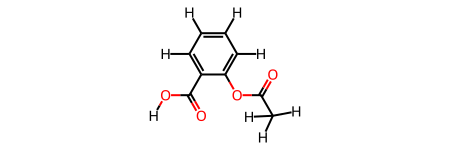

In [3]:
mol = Chem.AddHs(mol, addCoords=True)
mol

【解説】**`Chem.AddHs()`** メソッド

既存の分子オブジェクトに対して、水素原子（Hydrogen atoms）を付加する操作を行うものです。水素付加後の分子オブジェクトは、オリジナルとは異なる新たなインスタンスであるため、元の分子オブジェクトを直接変更するわけではない点に留意が必要です。

```python
mol = Chem.AddHs(mol, addCoords=True)
```

- `addCoords=True` ：　もとの分子が三次元座標（原子位置情報）を有している場合には、追加される水素原子にも座標が補完されます。すなわち、適切な立体配置が維持される形で水素が付加されます。
- `addCoords=False`（デフォルト）：水素原子に座標は与えられず、単に結合情報のみが付加されます。

## 2.コンフォーマー生成
対象分子に対して複数の三次元コンフォーマー（3D conformers）を生成する工程を実施します。

In [6]:
# 初期設定
confs = 1000        # コンフォーマーの発生数
rms = 0.5           # 類似した構造を排除する枝刈りレベル
pickup = 1          # コンフォーマーの選択数
forcefield = "uff"  # "uff" または "mmff"

In [7]:
#コンフォーマー探索
cids = AllChem.EmbedMultipleConfs(
    mol,
    numConfs=confs,
    pruneRmsThresh=rms,
    randomSeed=1234
)

print(f"生成されたコンフォーマー数: {len(cids)}")

生成されたコンフォーマー数: 2


---

【解説】AllChem.EmbedMultipleConfs()メソッドについて

`rdkit.Chem.AllChem.EmbedMultipleConfs()` は、指定した分子（`Mol`オブジェクト）に対して、**複数の三次元コンフォーマー**（3D conformers）を生成するための関数です。分子モデリング、立体配座探索、エネルギー最適化など、下流の化学情報学プロセスにおいて必須となる初期構造群を提供します。


#### 1. 主な引数

| 引数 | 説明 |
|:---|:---|
| `mol` | コンフォーマーを生成する対象の`Mol`オブジェクト。 |
| `numConfs` | 生成を試みるコンフォーマーの最大数（デフォルト：10）。 |
| `pruneRmsThresh` | 枝刈り（pruning）閾値。生成されたコンフォーマー同士のRMSD（Root Mean Square Deviation）がこの値未満であれば、冗長と見なして破棄される（デフォルト：-1.0、すなわち枝刈りを行わない）。 |
| `randomSeed` | 乱数生成器のシード。固定することで結果の再現性を確保できる。 |
| `useExpTorsionAnglePrefs` | 既知のトーション角情報（例えば結晶構造から得られたもの）を利用するか（デフォルト：`True`）。 |
| `useBasicKnowledge` | 一般的な化学構造知識（例えば、sp²炭素は平面構造を取るべき等）を利用するか（デフォルト：`True`）。 |


#### 2. 戻り値

関数は、**生成されたコンフォーマーのID番号（`confId`）のリスト** を返却する。各IDは、`Mol`オブジェクト内の個々のコンフォーマーにアクセスする際に用いられる。例えば、生成されたコンフォーマーに対して個別にエネルギー最適化やファイル出力を行う際、`confId`を指定することが求められる。

---

## 3.実行（コンフォーマー探索）
生成された複数の三次元コンフォーマーそれぞれに対して、力場計算を用いてエネルギー最適化を行い、さらに最適化後のエネルギーを算出します。ff.Minimize() を呼び出すことで、対象コンフォーマーのエネルギー最小化計算（構造緩和）が実行され、力場に基づき、結合長、結合角、二面角、非結合性相互作用などが考慮されながら、構造は局所的なエネルギー極小点へと緩和されます。最適化後に得られたエネルギー値と対応するコンフォーマーIDは、タプル (cid, energy) の形式でリスト energies に格納されます。このリストは、たとえば最も安定なコンフォーマーを選択するなど、後続の処理に利用されます。

In [8]:
# コンフォーマーごとのエネルギー最適化
energies = []

for cid in cids:
    if forcefield.lower() == "uff":
        ff = AllChem.UFFGetMoleculeForceField(mol, confId=cid)
    elif forcefield.lower() == "mmff":
        props = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94')
        ff = AllChem.MMFFGetMoleculeForceField(mol, props, confId=cid)

    ff.Minimize()
    energy = ff.CalcEnergy()
    energies.append((cid, energy))

【解説】
#### forcefield が `'uff'` のとき

```python
ff = AllChem.UFFGetMoleculeForceField(mol, confId=cid)
ff.Minimize()
energies.append((ff.CalcEnergy(), cid))
```

- UFF（Universal Force Field）を用いて最適化。
- `Minimize()` でエネルギー最小化。
- `CalcEnergy()` で最小化後のエネルギーを取得。
- `(エネルギー, コンフォーマーID)` のタプルとしてリストに追加。

#### forcefield が `'mmff'` のとき

```python
props = AllChem.MMFFGetMoleculeProperties(mol)
```

- MMFF（Merck Molecular Force Field）ではまず `props`（分子の性質情報）を取得する必要があります。

```python
ff = AllChem.MMFFGetMoleculeForceField(mol, props, confId=cid)
ff.Minimize()
energies.append((ff.CalcEnergy(), cid))
```

- `props` を使ってMMFF用の力場を生成。
- `Minimize()` → `CalcEnergy()` → 追加、は UFF と同様。


## 4.最安定構造のファイル出力
その後、最安定となった構造について.mol, .xyz, .gjf ファイルとして保存を行います。

In [9]:
# ソート用の関数を定義
def get_energy(item):
    return item[1]

# エネルギーでソートして最も低いものだけ選択
energies.sort(key=get_energy)

In [21]:
energies

[(1, 23.812173743744232), (0, 23.880717993872)]

In [27]:
# 最小エネルギーのコンフォーマーIDを1つだけ取得
best_cids = energies[0][0]

In [28]:
best_cids

1

In [30]:
# 保存
base_name = 'optimized_conformer_1'

# molファイル保存
molfile = base_name + '.mol'
Chem.MolToMolFile(mol, molfile, confId=best_cids)

print(f"コンフォーマー {best_cids} を {molfile} に保存しました。")

コンフォーマー 1 を optimized_conformer_1.mol に保存しました。
コンフォーマー選択＆最適化完了！


In [36]:
# 選ばれたコンフォーマーだけを保存（.mol, .xyz., .gifの３形式で保存）

# xyzファイル保存
xyzfile = base_name + '.xyz'

with open(xyzfile, 'w') as f:
    conf = mol.GetConformer(best_cids)
    f.write(f"{mol.GetNumAtoms()}\n\n")
    for atom in mol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        f.write(f"{atom.GetSymbol():<2} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}\n")
        
print(f"コンフォーマー {best_cids} を {xyzfile} に保存しました。")

# gjfファイル保存
gjffile = base_name + '.gjf'

with open(gjffile, 'w') as f:
    f.write("%nproc=4\n%mem=8GB\n#p opt freq b3lyp/6-31g(d)\n\n")
    f.write(f"{base_name}\n\n")
    f.write("0 1\n")  # (電荷、スピン多重度)
    for atom in mol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        f.write(f"{atom.GetSymbol():<2} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}\n")
    f.write("\n")
    
print(f"コンフォーマー {best_cids} を {gjffile} に保存しました。")

コンフォーマー 1 を optimized_conformer_1.xyz に保存しました。
コンフォーマー 1 を optimized_conformer_1.gjf に保存しました。


## 5.最安定構造の可視化
show_3D_from_xyz() を使ってpy3Dmolから、最安定構造のコンフォーマーを可視化します。

In [12]:
import py3Dmol

def show_3D_from_xyz(xyz_path, width=400, height=400, background='#e1e1e1'):
    with open(xyz_path, 'r') as f:
        xyz = f.read()

    view = py3Dmol.view(width=width, height=height)
    
    view.addModel(xyz, 'xyz')
    view.setStyle({'stick': {}})
    view.setBackgroundColor(background)
    view.zoomTo()
    
    return view.show()

In [13]:
# 最初のファイルだけ表示
show_3D_from_xyz('optimized_conformer_1.xyz')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.